# **`Flower Recognition`**

We import the libraries that we'll be using thorughout this notebook.

In [2]:
import os
import math
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf
from matplotlib.pyplot import imshow
from sklearn.metrics   import confusion_matrix, roc_curve, classification_report
from tensorflow        import keras
from keras.models      import Sequential
from keras.utils       import image_dataset_from_directory
from keras.layers      import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks         import  EarlyStopping, ReduceLROnPlateau
import splitfolders

## Dataset

The first thing that we're going to do is analyze our dataset. This dataset was recovered from **[Kaggle](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download&select=flowers)**, uploaded from *ALEXANDER MAMAEV*

The dataset contains multiple images from five kind of flowers, including daisy, dandelion, rose, sunflower and tulips.

In [10]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
inputFolder = '../data/flowers/'

Image daisy shape: (263, 320, 3)
There are 764 images of daisy
Image dandelion shape: (213, 320, 3)
There are 1052 images of dandelion
Image rose shape: (240, 179, 3)
There are 784 images of rose
Image sunflower shape: (330, 500, 3)
There are 733 images of sunflower
Image tulip shape: (209, 320, 3)
There are 984 images of tulip


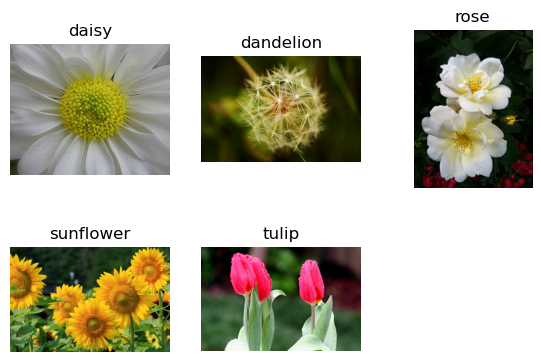

In [12]:
plt.figure(figsize=(7, 7))
for i in range(len(classes)):
  img_path = os.listdir(inputFolder + f'/{classes[i]}/')[0]
  img = image.load_img(inputFolder + f'/{classes[i]}/'  + img_path)
  print(f'Image {classes[i]} shape: {image.img_to_array(img).shape}')
  print(f'There are {len(os.listdir(inputFolder + f"/{classes[i]}/"))} images of {classes[i]}')
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(classes[i])
  plt.axis("off")

Now that we've seen how the flowers and our dataset looks, it's time to load our dataset to train our model. For this, we will generate the validation, training, and testing dataset.

In [19]:
output_dir = '../data/'
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [20]:
splitfolders.ratio(inputFolder, output=output_dir, seed=1337, ratio=(train_ratio, val_ratio, test_ratio))

In [24]:
train_dir = '../data/train/'
val_dir = '../data/val/'
test_dir = '../data/test/'

In [25]:
train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=40,
        width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, 
        horizontal_flip=True,fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
print('Train:')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224), batch_size=32,
        class_mode='categorical',
        seed=123
    )

In [ ]:
print('Val:')
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224), batch_size=32,
        class_mode='categorical',
        seed=123
    )

In [26]:
print('Test:')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224), batch_size=32,
        class_mode='categorical',
        seed=123
    )

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


## Developing our model

For our model, we'll use transfer learning by loading the pretrained architecture Mobilnet.

In [ ]:
IMG_SHAPE = (224, 224, 3)

In [ ]:
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
pre_trained_model.trainable = False

Now that we've loaded the pre-trained architecture, we'll add the proper settings for our classification task.


In [ ]:
x = GlobalAveragePooling2D()(pre_trained_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(len(classes), activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
starting_lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=starting_lr), loss='categorical_crossentropy', metrics=['accuracy'])

## Callbacks

Now that we've declared our model, we'll generate callbacks to help during the training of our model

In [ ]:
early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, verbose=1, min_lr=0.00001)